# Data Transformation Algorithm for Data Protection

Project Report by Allentine Paulis

# Table of Contents
* [Project Description](#description)
* [Data](#data)
* [Step 1. Data Preprocessing & Exploration](#preprocessing)
    * [1. Initialization](#initial)
    * [2. Load Data](#load)
    * [3. EDA](#eda)
* [Step 2. Task 1 : Similar Customers](#task1)
* [Step 3. Task 2 : Is Customer Likely to Receive Insurance Benefit](#task2)  
* [Step 4. Task 3 : Linear Regression](#task3)
* [Step 5. Task 4 : Obfuscating Data](#task4)
* [Step 6. Proof That Data Obfuscation Can Work with LR](#proof)
* [Step 7. Test Linear Regression With Data Obfuscation](#test)
* [Step 8. Overall conclusion](#allconclusion)
* [Step 9. Appendices](#appendices)

# Project Description <a class="anchor" id="description"></a>
In this project, The Sure Tomorrow insurance company wants to solve several tasks with the help of Machine Learning and we are going to evaluate that possibility.

- Task 1: Find customers who are similar to a given customer. This will help the company's agents with marketing.
- Task 2: Predict whether a new customer is likely to receive an insurance benefit. Can a prediction model do better than a dummy model?
- Task 3: Predict the number of insurance benefits a new customer is likely to receive using a linear regression model.
- Task 4: Protect clients' personal data without breaking the model from the previous task. 

It's necessary to develop a data transformation algorithm that would make it hard to recover personal information if the data fell into the wrong hands. This is called data masking, or data obfuscation. But the data should be protected in such a way that the quality of machine learning models doesn't suffer. You don't need to pick the best model, just prove that the algorithm works correctly.

# Data <a class="anchor" id="data"></a>
The dataset is stored in https://code.s3.yandex.net/datasets/insurance_us.csv
- **Features**: insured person's gender, age, salary, and number of family members.
- **Target**: number of insurance benefits received by an insured person over the last five years.

# Data Preprocessing & Exploration<a class="anchor" id="preprocessing"></a>

## Initialization<a class="anchor" id="initial"></a>

In [17]:
import numpy as np
import pandas as pd

import seaborn as sns

import sklearn.linear_model
import sklearn.metrics
from sklearn.neighbors import NearestNeighbors
import sklearn.preprocessing

from sklearn.model_selection import train_test_split

from IPython.display import display

## Load Data<a class="anchor" id="load"></a>

Load data and conduct a basic check that it's free from obvious issues.

In [2]:
df = pd.read_csv('https://code.s3.yandex.net/datasets/insurance_us.csv')

In [3]:
df.head()

Gender   Age   Salary  Family members  Insurance benefits
0       1  41.0  49600.0               1                   0
1       0  46.0  38000.0               1                   1
2       0  29.0  21000.0               0                   0
3       0  21.0  41700.0               2                   0
4       1  28.0  26100.0               0                   0

We rename the colums to make the code look more consistent with its style.

In [4]:
df = df.rename(columns={'Gender': 'gender', 'Age': 'age', 'Salary': 'income', 'Family members': 'family_members', 'Insurance benefits': 'insurance_benefits'})

In [5]:
df.sample(10)

gender   age   income  family_members  insurance_benefits
883        0  21.0  39400.0               1                   0
2505       1  53.0  45300.0               1                   2
2042       0  40.0  29200.0               2                   0
3534       1  39.0  30900.0               1                   0
2847       0  28.0  48900.0               1                   0
2180       0  39.0  51200.0               2                   0
808        0  30.0  51000.0               1                   0
1771       1  38.0  20900.0               2                   0
243        0  19.0  36900.0               1                   0
966        1  20.0  44500.0               0                   0

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 5 columns):
gender                5000 non-null int64
age                   5000 non-null float64
income                5000 non-null float64
family_members        5000 non-null int64
insurance_benefits    5000 non-null int64
dtypes: float64(2), int64(3)
memory usage: 195.4 KB


In [7]:
# fix the age type (from float to int)
df['age'] = df['age'].astype(int)

In [8]:
# check to see that the conversion was successful
df.dtypes

gender                  int64
age                     int64
income                float64
family_members          int64
insurance_benefits      int64
dtype: object

In [9]:
# data's descriptive statistics. 
df.describe()

gender          age        income  family_members  \
count  5000.000000  5000.000000   5000.000000     5000.000000   
mean      0.499000    30.952800  39916.360000        1.194200   
std       0.500049     8.440807   9900.083569        1.091387   
min       0.000000    18.000000   5300.000000        0.000000   
25%       0.000000    24.000000  33300.000000        0.000000   
50%       0.000000    30.000000  40200.000000        1.000000   
75%       1.000000    37.000000  46600.000000        2.000000   
max       1.000000    65.000000  79000.000000        6.000000   

       insurance_benefits  
count         5000.000000  
mean             0.148000  
std              0.463183  
min              0.000000  
25%              0.000000  
50%              0.000000  
75%              0.000000  
max              5.000000

In [10]:
df.isna().sum()

gender                0
age                   0
income                0
family_members        0
insurance_benefits    0
dtype: int64

No missing values.

In [11]:
df.duplicated().sum()

153

There are 153 duplicated values

In [12]:
df = df.drop_duplicates()

Drop the duplicates.

## EDA<a class="anchor" id="eda"></a>

Let's quickly check whether there are certain groups of customers by looking at the pair plot.

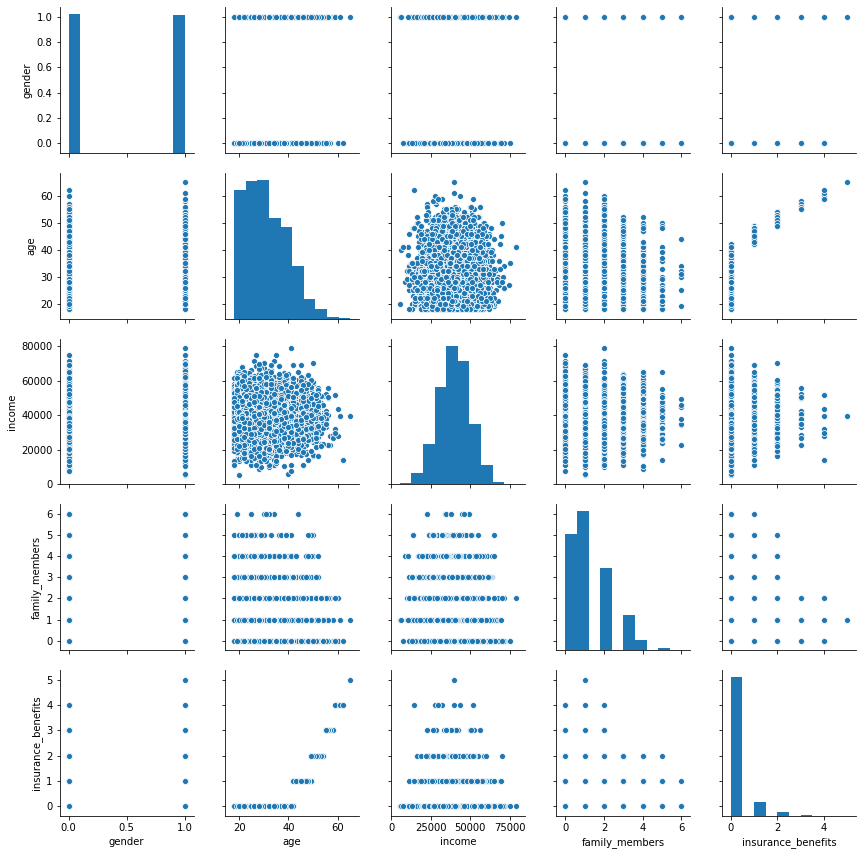

In [13]:
g = sns.pairplot(df)
g.fig.set_size_inches(12, 12)

Ok, it is a bit difficult to spot obvious groups (clusters) as it is difficult to combine several variables simultaneously (to analyze multivariate distributions). That's where LA and ML can be quite handy.

# Task 1. Similar Customers<a class="anchor" id="task1"></a>

In the language of ML, it is necessary to develop a procedure that returns k nearest neighbors (objects) for a given object based on the distance between the objects.

To solve the task, we can try different distance metrics.

Write a function that returns k nearest neighbors for an $n^{th}$ object based on a specified distance metric. The number of received insurance benefits should not be taken into account for this task. 

We can use a ready implementation of the kNN algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html#sklearn.neighbors.NearestNeighbors)) or use our own.

Test it for four combination of two cases
- Scaling
  - the data is not scaled
  - the data is scaled with the [MaxAbsScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html) scaler
- Distance Metrics
  - Euclidean
  - Manhattan

Answer these questions:
- Does the data being not scaled affect the kNN algorithm? If so, how does that appear?
- How similar are the results using the Manhattan distance metric (regardless of the scaling)?

In [14]:
feature_names = ['gender', 'age', 'income', 'family_members']

In [18]:
def get_knn(df, n, k, metric):
    
    """
    Returns k nearest neighbors

    :param df: pandas DataFrame used to find similar objects within
    :param n: object no for which the nearest neighbours are looked for
    :param k: the number of the nearest neighbours to return
    :param metric: name of distance metric
    """

    nbrs = NearestNeighbors(n_neighbors=k, metric = metric).fit(df[feature_names])
    nbrs_distances, nbrs_indices = nbrs.kneighbors([df.iloc[n][feature_names]], k, return_distance=True)
    
    print(nbrs_distances)
    print(nbrs_indices)
    
    df_res = pd.concat([
        df.iloc[nbrs_indices[0]], 
        pd.DataFrame(nbrs_distances.T, index=nbrs_indices[0], columns=['distance'])
        ], axis=1)
    
    return df_res

In [19]:
get_knn(df, 10, 5 , 'euclidean')

[[0.         1.         1.41421356 1.41421356 1.73205081]]
[[  10 3924 3169 2007 1919]]


gender   age   income  family_members  insurance_benefits  distance
10       1.0  25.0  36600.0             1.0                 0.0  0.000000
1919     NaN   NaN      NaN             NaN                 NaN  1.732051
1949     0.0  24.0  36600.0             0.0                 0.0       NaN
2007     NaN   NaN      NaN             NaN                 NaN  1.414214
2037     1.0  26.0  36600.0             0.0                 0.0       NaN
3169     NaN   NaN      NaN             NaN                 NaN  1.414214
3247     1.0  26.0  36600.0             2.0                 0.0       NaN
3924     NaN   NaN      NaN             NaN                 NaN  1.000000
4039     1.0  25.0  36600.0             2.0                 0.0       NaN

Scaling the data.

In [ ]:
feature_names = ['gender', 'age', 'income', 'family_members']

transformer_mas = sklearn.preprocessing.MaxAbsScaler().fit(df[feature_names].to_numpy())

df_scaled = df.copy()
df_scaled.loc[:, feature_names] = transformer_mas.transform(df[feature_names].to_numpy())

In [ ]:
df_scaled.sample(5)

Now, let's get similar records for a given one for every combination

In [ ]:
// what records? what does this task want? 

Answers to the questions

**Does the data being not scaled affect the kNN algorithm? If so, how does that appear?** 

Put your answer here.

**How similar are the results using the Manhattan distance metric (regardless of the scaling)?** 

Put your answer here.

# Task 2. Is Customer Likely to Receive Insurance Benefit?<a class="anchor" id="task2"></a>

In terms of machine learning we can look at this like a binary classification task.

With `insurance_benefits` being more than zero as the target, evaluate whether the kNN classification approach can do better than a dummy model.

Instructions:
- Build a KNN-based classifier and measure its quality with the F1 metric for k=1..10 for both the original data and the scaled one. That'd be interesting to see how k may influece the evaluation metric, and whether scaling the data makes any difference. You can use a ready implemention of the kNN classification algorithm from scikit-learn (check [the link](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)) or use your own.
- Build the dummy model which is just random for this case. It should return "1" with some probability. Let's test the model with four probability values: 0, the probability of paying any insurance benefit, 0.5, 1.

The probability of paying any insurance benefit can be defined as

$$
P\{\text{insurance benefit received}\}=\frac{\text{number of clients received any insurance benefit}}{\text{total number of clients}}.
$$

Split the whole data in the 70:30 proportion for the training/testing parts.

In [ ]:
# calculate the target

df['insurance_benefits_received'] = #<your code here>

In [ ]:
# check for the class imbalance with value_counts()

# <your code here>

In [ ]:
def eval_classifier(y_true, y_pred):
    
    f1_score = sklearn.metrics.f1_score(y_true, y_pred)
    print(f'F1: {f1_score:.2f}')
    
    cm = sklearn.metrics.confusion_matrix(y_true, y_pred, normalize='all')
    print('Confusion Matrix')
    print(cm)

In [ ]:
# generating output of a random model

def rnd_model_predict(P, size, seed=42):

    rng = np.random.default_rng(seed=seed)
    return rng.binomial(n=1, p=P, size=size)

In [ ]:
for P in [0, df['insurance_benefits_received'].sum() / len(df), 0.5, 1]:

    print(f'The probability: {P:.2f}')
    y_pred_rnd = # <your code here> 
        
    eval_classifier(df['insurance_benefits_received'], y_pred_rnd)
    
    print()

# Task 3. Regression (with Linear Regression)<a class="anchor" id="task3"></a>

With `insurance_benefits` as the target, evaluate what RMSE would be for a Linear Regression model.

Build your own implementation of LR. For that, recall how the linear regression task's solution is formulated in terms of LA. Check RMSE for both the original data and the scaled one. Can you see any difference in RMSE between these two cases?

Let's denote
- $X$ — feature matrix, each row is a case, each column is a feature, the first column consists of unities
- $y$ — target (a vector)
- $\hat{y}$ — estimated tagret (a vector)
- $w$ — weight vector

The task of linear regression in the language of matrices can be formulated as

$$
y = Xw
$$

The training objective then is to find such $w$ that it would minimize the L2-distance (MSE) between $Xw$ and $y$:

$$
\min_w d_2(Xw, y) \quad \text{or} \quad \min_w \text{MSE}(Xw, y)
$$

It appears that there is analytical solution for the above:

$$
w = (X^T X)^{-1} X^T y
$$

The formula above can be used to find the weights $w$ and the latter can be used to calculate predicted values

$$
\hat{y} = X_{val}w
$$

Split the whole data in the 70:30 proportion for the training/validation parts. Use the RMSE metric for the model evaluation.

In [ ]:
class MyLinearRegression:
    
    def __init__(self):
        
        self.weights = None
    
    def fit(self, X, y):
        
        # adding the unities
        X2 = np.append(np.ones([len(X), 1]), X, axis=1)
        self.weights = # <your code here>

    def predict(self, X):
        
        # adding the unities
        X2 = # <your code here>
        y_pred = # <your code here>
        
        return y_pred

In [ ]:
def eval_regressor(y_true, y_pred):
    
    rmse = math.sqrt(sklearn.metrics.mean_squared_error(y_true, y_pred))
    print(f'RMSE: {rmse:.2f}')
    
    r2_score = math.sqrt(sklearn.metrics.r2_score(y_true, y_pred))
    print(f'R2: {r2_score:.2f}')    

In [ ]:
X = df[['age', 'gender', 'income', 'family_members']].to_numpy()
y = df['insurance_benefits'].to_numpy()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12345)

lr = MyLinearRegression()

lr.fit(X_train, y_train)
print(lr.weights)

y_test_pred = lr.predict(X_test)
eval_regressor(y_test, y_test_pred)

# Task 4. Obfuscating Data<a class="anchor" id="task4"></a>

It best to obfuscate data by multiplying the numerical features (remember, they can be seen as the matrix $X$) by an invertible matrix $P$. 

$$
X' = X \times P
$$

Try to do that and check how the features' values will look like after the transformation. By the way, the intertible property is important here so make sure that $P$ is indeed invertible.

You may want to review the 'Matrices and Matrix Operations -> Matrix Mupliplication' lesson to recall the rule of matrix multiplication and its implementation with NumPy.

In [ ]:
personal_info_column_list = ['gender', 'age', 'income', 'family_members']
df_pn = df[personal_info_column_list]

In [ ]:
X = df_pn.to_numpy()

Generating a random matrix $P$.

In [ ]:
rng = np.random.default_rng(seed=42)
P = rng.random(size=(X.shape[1], X.shape[1]))

Checking the matrix $P$ is invertible

Can you guess the customers' ages or income after the transformation?

Can you recover the original data from $X'$ if you know $P$? Try to check that with calculations by moving $P$ from the right side of the formula above to the left one. The rules of matrix multiplcation are really helpful here.

Print all three cases for a few customers
- The original data
- The transformed one
- The reversed (recovered) one

You can probably see that some values are not exactly the same as they are in the original data. What might be the reason for that?

## Proof That Data Obfuscation Can Work with LR<a class="anchor" id="proof"></a>

The regression task has been solved with linear regression in this project. Your next task is to prove _analytically_ that the given obfuscation method won't affect linear regression in terms of predicted values i.e. their values will remain the same. Can you believe that? Well, you don't have to, you should prove it!

So, the data is obfuscated and there is $X \times P$ instead of just $X$ now. Consequently, there are other weights $w_P$ as
$$
w = (X^T X)^{-1} X^T y \quad \Rightarrow \quad w_P = [(XP)^T XP]^{-1} (XP)^T y
$$

How would $w$ and $w_P$ be linked if you simplify the formula for $w_P$ above? 

What would be predicted values with $w_P$? 

What does that mean for the quality of linear regression if you measure it with RMSE?

Check Appendix B Properties of Matrices in the end of the notebook. There are useful formulas in there!

No code is necessary in this section, only analytical explanation!

**Answer**

**Analytical proof**

## Test Linear Regression With Data Obfuscation<a class="anchor" id="test"></a>

Now, let's prove Linear Regression can work computationally with the chosen obfuscation transformation.

Build a procedure or a class that runs Linear Regression optionally with the obfuscation. You can use either a ready implementation of Linear Regression from sciki-learn or your own.

Run Linear Regression for the original data and the obfuscated one, compare the predicted values and the RMSE, $R^2$ metric values. Is there any difference?

**Procedure**

- Create a square matrix $P$ of random numbers.
- Check that it is invertible. If not, repeat the first point until we get an invertible matrix.
- <! your comment here !>
- Use $XP$ as the new feature matrix

# Overall Conclusions<a class="anchor" id="allconclusion"></a>

# Checklist

Type 'x' to check. Then press Shift+Enter.

- [x]  Jupyter Notebook is open
- [ ]  Code is error free
- [ ]  The cells are arranged in order of logic and execution
- [ ]  Task 1 has been performed
    - [ ]  There is the procedure that can return k similar customers for a given one
    - [ ]  The procedure is tested for all four proposed combinations
    - [ ]  The questions re the scaling/distances are answered
- [ ]  Task 2 has been performed
    - [ ]  The random classification model is built and tested for all for probability levels
    - [ ]  The kNN classification model is built and tested for both the original data and the scaled one, the F1 metric is calculated.
- [ ]  Task 3 has been performed
    - [ ]  The linear tegression solution is implemented with matrix operations.
    - [ ]  RMSE is calculated for the implemented solution.
- [ ]  Task 4 has been performed
    - [ ]  The data is obfuscated with a random and invertible matrix P
    - [ ]  The obfuscated data is recoved, few examples are printed out
    - [ ]  The analytical proof that the transformation does not affect RMSE is provided 
    - [ ]  The computational proof that the transformation does not affect RMSE is provided
- [ ]  Conclusions have been made

# Appendices <a class="anchor" id="appendices"></a>

## Appendix A: Writing Formulas in Jupyter Notebooks

You can write formulas in your Jupyter Notebook in a markup language provided by a high-quality publishing system called $\LaTeX$ (pronounced "Lah-tech"), and they will look like formulas in textbooks.

To put a formula in a text, put the dollar sign (\\$) before and after the formula's text e.g. $\frac{1}{2} \times \frac{3}{2} = \frac{3}{4}$ or $y = x^2, x \ge 1$.

If a formula should be in its own paragraph, put the double dollar sign (\\$\\$) before and after the formula text e.g.

$$
\bar{x} = \frac{1}{n}\sum_{i=1}^{n} x_i.
$$

The markup language of [LaTeX](https://en.wikipedia.org/wiki/LaTeX) is very popular among people who use formulas in their articles, books and texts. It can be complex but its basics are easy. Check this two page [cheatsheet](http://tug.ctan.org/info/undergradmath/undergradmath.pdf) for learning how to compose the most common formulas.

## Appendix B: Properties of Matrices

Matrices have many properties in Linear Algebra. A few of them are listed here which can help with the analytical proof in this project.

<table>
<tr>
<td>Distributivity</td><td>$A(B+C)=AB+AC$</td>
</tr>
<tr>
<td>Non-commutativity</td><td>$AB \neq BA$</td>
</tr>
<tr>
<td>Associative property of multiplication</td><td>$(AB)C = A(BC)$</td>
</tr>
<tr>
<td>Multiplicative identity property</td><td>$IA = AI = A$</td>
</tr>
<tr>
<td></td><td>$A^{-1}A = AA^{-1} = I$
</td>
</tr>    
<tr>
<td></td><td>$(AB)^{-1} = B^{-1}A^{-1}$</td>
</tr>    
<tr>
<td>Reversivity of the transpose of a product of matrices,</td><td>$(AB)^T = B^TA^T$</td>
</tr>    
</table>